In [242]:
import pandas as pd
import matplotlib.pyplot as plt

In [243]:
country_codes = pd.read_csv('https://datahub.io/core/country-codes/r/country-codes.csv')
country_codes = country_codes.set_index('ISO3166-1-Alpha-2')
country_codes = country_codes[['ISO3166-1-Alpha-3']]

print(country_codes.shape)
country_codes.head()

(250, 1)


,ISO3166-1-Alpha-3
ISO3166-1-Alpha-2,
TW,TWN
AF,AFG
AL,ALB
DZ,DZA
AS,ASM


In [244]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request

population_url = 'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'
request = urllib.request.urlopen(population_url)
populations = None

with ZipFile(BytesIO(request.read())) as zip_file:
    for contained_file in zip_file.namelist():
        if not contained_file.startswith('Metadata'):
            print(contained_file)
            populations = pd.read_csv(zip_file.open(contained_file), skiprows=4)

populations = populations.rename(columns={'Country Code': 'ISO3166-1-Alpha-3',
                                          '2019': 'Population'})
populations = populations.set_index('ISO3166-1-Alpha-3')
populations = populations[['Population']]

print(populations.shape)
populations.head()

API_SP.POP.TOTL_DS2_en_csv_v2_1308146.csv
(264, 1)


,Population
ISO3166-1-Alpha-3,
ABW,106314.0
AFG,38041754.0
AGO,31825295.0
ALB,2854191.0
AND,77142.0


In [245]:
covid = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', skipinitialspace=True)
print(covid.shape)

covid = covid.merge(country_codes, left_on='Country_code', right_on='ISO3166-1-Alpha-2', how="inner")
print(covid.shape)

covid = covid.merge(populations, on='ISO3166-1-Alpha-3', how="inner")
covid = covid.set_index(['Date_reported', 'Country_code'])

print(covid.shape)
covid.head()

(35114, 8)
(35306, 9)
(32830, 8)


,,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,ISO3166-1-Alpha-3,Population
Date_reported,Country_code,,,,,,,,
2020-02-24,AF,Afghanistan,EMRO,5,5,0,0,AFG,38041754.0
2020-02-25,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0
2020-02-26,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0
2020-02-27,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0
2020-02-28,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0


In [246]:
multiplier_100k = 100000
covid['New_cases_per_100k'] = covid['New_cases'] / (covid['Population'] / multiplier_100k)

covid.head(100)

,,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,ISO3166-1-Alpha-3,Population,New_cases_per_100k
Date_reported,Country_code,,,,,,,,,
2020-02-24,AF,Afghanistan,EMRO,5,5,0,0,AFG,38041754.0,0.013143
2020-02-25,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,0.000000
2020-02-26,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,0.000000
2020-02-27,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,0.000000
2020-02-28,AF,Afghanistan,EMRO,0,5,0,0,AFG,38041754.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-05-29,AF,Afghanistan,EMRO,643,13659,11,246,AFG,38041754.0,1.690248
2020-05-30,AF,Afghanistan,EMRO,784,14443,2,248,AFG,38041754.0,2.060893
2020-05-31,AF,Afghanistan,EMRO,651,15094,2,250,AFG,38041754.0,1.711278


In [247]:
# countries = ['DE', 'GB', 'CH', 'MT', 'HR', 'US', 'BR', 'CN']
countries = ['DE', 'GB', 'CH', 'MT', 'HR', 'CN']

new_cases_per_100k = pd.DataFrame(data=None, index=pd.Index(data=[],name='Date reported'))

for country in countries:
    data = covid.xs(country, level=1)
    country_name = data['Country'][0]
    print(country_name)
    data = data[['New_cases_per_100k']]
    data = data.rename(columns={'New_cases_per_100k': country_name})
    new_cases_per_100k = new_cases_per_100k.join(data, how="outer")

new_cases_per_100k


Germany
The United Kingdom
Switzerland
Malta
Croatia
China


,Germany,The United Kingdom,Switzerland,Malta,Croatia,China
Date_reported,,,,,,
2020-01-04,NaN,NaN,NaN,NaN,NaN,0.000072
2020-01-05,NaN,NaN,NaN,NaN,NaN,0.000000
2020-01-06,NaN,NaN,NaN,NaN,NaN,0.000215
2020-01-07,NaN,NaN,NaN,NaN,NaN,0.000000
2020-01-08,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...
2020-08-11,1.161996,1.220928,1.224514,4.575721,1.106331,0.008085
2020-08-12,1.474749,1.717678,2.180801,0.000000,2.237246,0.004364
2020-08-13,1.738183,1.509701,3.183736,15.517663,3.196066,0.005867


D:\Users\Michael\git\covid-notebooks\env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date_reported'>

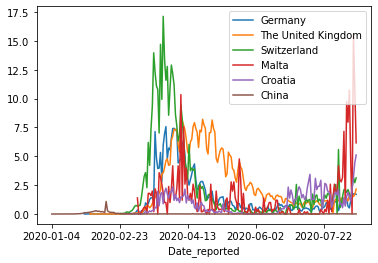

In [248]:
new_cases_per_100k.plot()